<a href="https://colab.research.google.com/github/hache22/cancer_issue/blob/main/Cancer_issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilidad Supervivencia de Cancer en Pacientes con patologias.
## Modelo creado en base al set de datos: "Cancer Issue" obtenido de kaggle: [Datos](https://www.kaggle.com/datasets/preetigupta004/cancer-issue)
### Este proyecto analiza los datos del archivo `cancer_issue.csv`, el cual contiene información detallada sobre pacientes con cáncer.  La base de datos incluye información demográfica de los pacientes, su historial médico, el tipo de cáncer diagnosticado, los tratamientos recibidos y los resultados de supervivencia. El objetivo principal de este análisis es identificar los factores que influyen en el desarrollo del cáncer, la efectividad de los diferentes tratamientos y la tasa de supervivencia de los pacientes.  Los hallazgos de este análisis podrían proporcionar valiosas perspectivas para mejorar la atención médica y la investigación oncológica, con el potencial de contribuir a la mejora de los diagnósticos, tratamientos y resultados para pacientes con cáncer en el futuro.

# 1. Importacion de las Librerias y Datos para el analisis

In [ ]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


# 2. Carga de los Datos contenidos en el Set

In [ ]:
df = pd.read_csv('cancer_issue.csv')
print("Primeras filas del dataset:")
print(df.head())
print("\
Información del dataset:")
print(df.info())

Primeras filas del dataset:
   PatientID  Age  Gender Race/Ethnicity   BMI  SmokingStatus FamilyHistory  \
0          1   80  Female          Other  23.3         Smoker           Yes   
1          2   76    Male      Caucasian  22.4  Former Smoker           Yes   
2          3   69    Male          Asian  21.5         Smoker           Yes   
3          4   77    Male          Asian  30.4  Former Smoker           Yes   
4          5   89    Male      Caucasian  20.9         Smoker           Yes   

  CancerType Stage  TumorSize        TreatmentType   TreatmentResponse  \
0     Breast    II        1.7  Combination Therapy         No Response   
1      Colon    IV        4.7              Surgery         No Response   
2     Breast   III        8.3  Combination Therapy  Complete Remission   
3   Prostate    II        1.7            Radiation   Partial Remission   
4       Lung    IV        7.4            Radiation         No Response   

   SurvivalMonths Recurrence GeneticMarker HospitalR

 # 3. Crear características adicionales

In [ ]:
df['Age_BMI_Interaction'] = df['Age'] * df['BMI']
df['TumorSize_SurvivalRatio'] = df['TumorSize'] / df['SurvivalMonths']
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],
                           labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df['BMI_Category'] = df['BMI_Category'].cat.add_categories(['Unknown'])

# 4. Preprocesamiento
### Identificacion de columnas numéricas y categóricas

In [ ]:
caracteristicas_numericas = ['Age', 'BMI', 'TumorSize', 'SurvivalMonths', 'Age_BMI_Interaction', 'TumorSize_SurvivalRatio']
caracteristicas_categoricas = ['Gender', 'Race/Ethnicity', 'SmokingStatus', 'Stage', 'TreatmentType',
                       'TreatmentResponse', 'Recurrence', 'GeneticMarker', 'HospitalRegion', 'BMI_Category']

# Manejo de valores nulos

In [ ]:
df[caracteristicas_numericas] = df[caracteristicas_numericas].fillna(df[caracteristicas_numericas].mean())
df[caracteristicas_categoricas] = df[caracteristicas_categoricas].fillna('Unknown')

# Detección y manejo de outliers

In [ ]:
z_scores = zscore(df[caracteristicas_numericas])
df_sin_outliers = df[(np.abs(z_scores) < 3).all(axis=1)]

# Creacion de pipeline para preprocesamiento

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, caracteristicas_numericas),
        ('cat', categorical_transformer, caracteristicas_categoricas)
    ])


# 5. Preparacion de los Datos

In [ ]:
X = preprocessor.fit_transform(df_sin_outliers)

# Aplicacion PCA

In [ ]:
pca = PCA(n_components=0.95)  # Mantener 95% de la varianza
X_pca = pca.fit_transform(X)

In [ ]:
print("Dimensiones después de PCA:", X_pca.shape)
print("Varianza explicada acumulada:", np.cumsum(pca.explained_variance_ratio_))

Dimensiones después de PCA: (17401, 21)
Varianza explicada acumulada: [0.42280922 0.49983731 0.54544587 0.57625104 0.6069424  0.63716402
 0.66074199 0.68409858 0.7073728  0.73030445 0.75308017 0.77560724
 0.79799304 0.82015781 0.84207573 0.86378134 0.88221088 0.90023985
 0.91813379 0.93480844 0.95109754]


# Visualizando la varianza
### Se redefinió con éxito la secuencia de preprocesamiento y se aplicó PCA para reducir las dimensiones conservando el 95 % de la varianza. El conjunto de datos ahora tiene 21 componentes principales, como se muestra a continuación:

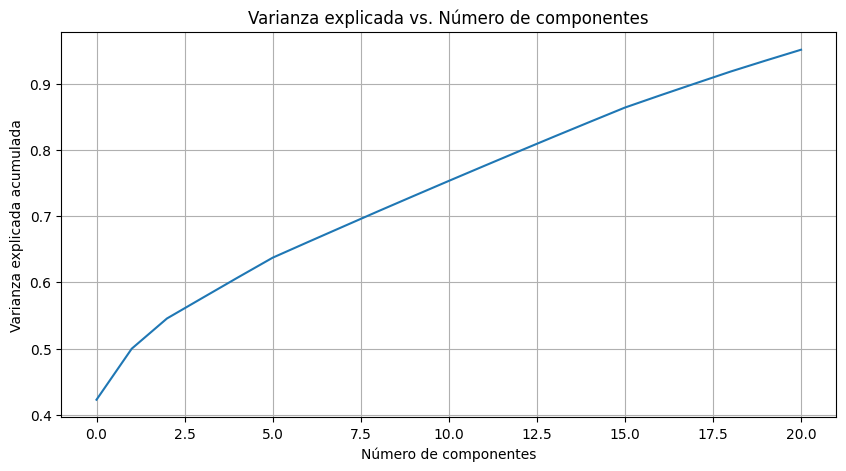

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada vs. Número de componentes')
plt.grid(True)
plt.show()

# 6. Creacion del modelo con K-Means para Clustering

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

In [ ]:
# Agrupación aglomerante
agglo = AgglomerativeClustering(n_clusters=8)
agglo_labels = agglo.fit_predict(X_pca)

In [ ]:
# Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=8, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)


In [ ]:
# Validación de los clusters
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_pca, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_pca, kmeans_labels)

agglo_silhouette = silhouette_score(X_pca, agglo_labels)
agglo_calinski = calinski_harabasz_score(X_pca, agglo_labels)
agglo_davies = davies_bouldin_score(X_pca, agglo_labels)

gmm_silhouette = silhouette_score(X_pca, gmm_labels)
gmm_calinski = calinski_harabasz_score(X_pca, gmm_labels)
gmm_davies = davies_bouldin_score(X_pca, gmm_labels)


In [ ]:
# Mostrar resultados de validación
print("Resultados de validación de clustering:")
print("\
K-means:")
print("Silhouette Score:", kmeans_silhouette)
print("Calinski-Harabasz Score:", kmeans_calinski)
print("Davies-Bouldin Score:", kmeans_davies)

print("\
Agglomerative Clustering:")
print("Silhouette Score:", agglo_silhouette)
print("Calinski-Harabasz Score:", agglo_calinski)
print("Davies-Bouldin Score:", agglo_davies)

print("\
Gaussian Mixture Model:")
print("Silhouette Score:", gmm_silhouette)
print("Calinski-Harabasz Score:", gmm_calinski)
print("Davies-Bouldin Score:", gmm_davies)

Resultados de validación de clustering:
K-means:
Silhouette Score: 0.08299291073802889
Calinski-Harabasz Score: 2565.5479416248763
Davies-Bouldin Score: 2.3198598626800253
Agglomerative Clustering:
Silhouette Score: 0.05401803746153505
Calinski-Harabasz Score: 2270.2968534440984
Davies-Bouldin Score: 2.904844132963814
Gaussian Mixture Model:
Silhouette Score: 0.03637185909127829
Calinski-Harabasz Score: 2002.2554743465423
Davies-Bouldin Score: 4.0154693681769436


# 7. Interpretabilidad y Visualizacion
## Creacion de perfiles cluster para K-means (el mejor modelo según las métricas)

In [ ]:

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df_clustered = df_sin_outliers.copy()
df_clustered['Cluster_KMeans'] = kmeans_labels

cluster_profiles = df_clustered.groupby('Cluster_KMeans').agg({
    'Age': 'mean',
    'BMI': 'mean',
    'TumorSize': 'mean',
    'SurvivalMonths': 'mean',
    'TreatmentResponse': lambda x: x.mode()[0],
    'Stage': lambda x: x.mode()[0],
    'CancerType': lambda x: x.mode()[0]
}).round(2)

In [ ]:
print("\
Perfiles de clusters (K-means):")
print(cluster_profiles)


Perfiles de clusters (K-means):
                  Age    BMI  TumorSize  SurvivalMonths  TreatmentResponse  \
Cluster_KMeans                                                               
0               72.05  24.79       5.05           73.66  Partial Remission   
1               54.34  29.52       6.77           11.29  Partial Remission   
2               35.83  34.88       5.11           73.89        No Response   
3               51.26  29.13       6.42            3.74  Partial Remission   
4               72.78  35.27       5.29           69.56        No Response   
5               53.66  29.08       6.67            6.11        No Response   
6               52.62  28.14       6.81           25.09        No Response   
7               35.88  23.86       5.07           73.89        No Response   

               Stage CancerType  
Cluster_KMeans                   
0                 IV     Breast  
1                 IV   Leukemia  
2                 II   Prostate  
3                

# Visualización de clusters en 2D usando PCA

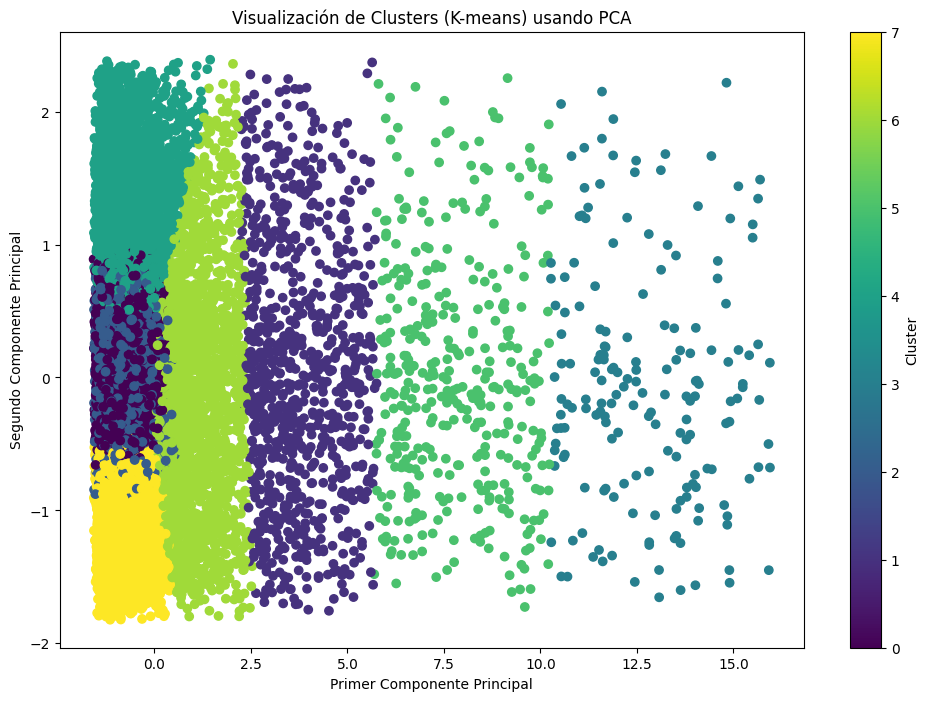

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('Visualización de Clusters (K-means) usando PCA')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.colorbar(label='Cluster')
plt.show()

# Análisis de características importantes por cluster

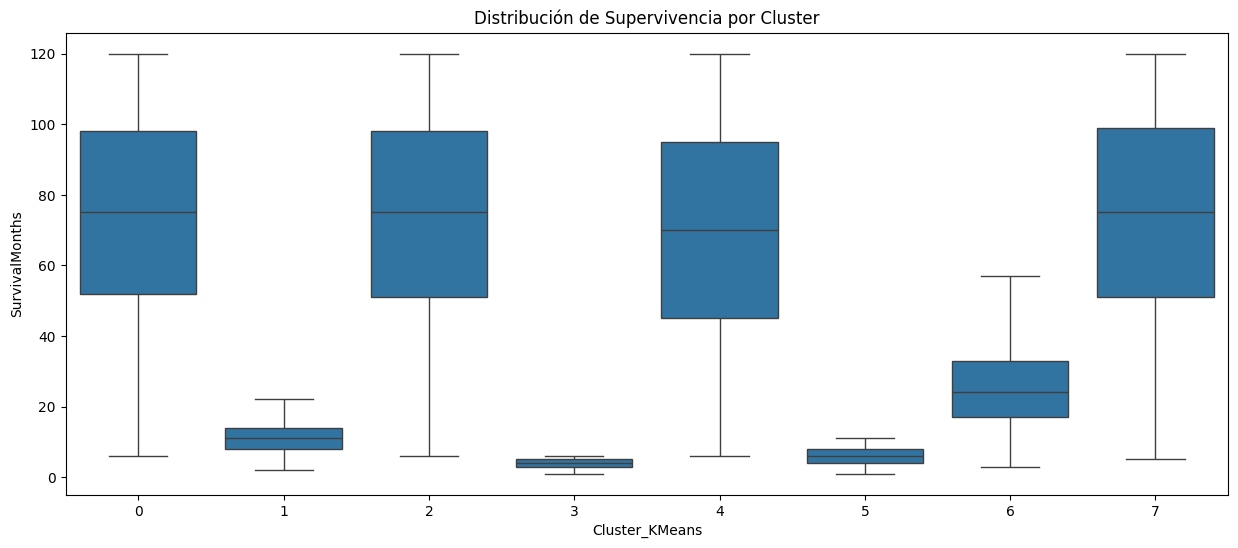

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_sin_outliers, x='Cluster_KMeans', y='SurvivalMonths')
plt.title('Distribución de Supervivencia por Cluster')
plt.show()

# Distribución de tipos de cáncer por cluster

In [ ]:

cancer_cluster_dist = pd.crosstab(df_sin_outliers['Cluster_KMeans'],
                                 df_sin_outliers['CancerType'],
                                 normalize='index') * 100

<Figure size 1500x800 with 0 Axes>

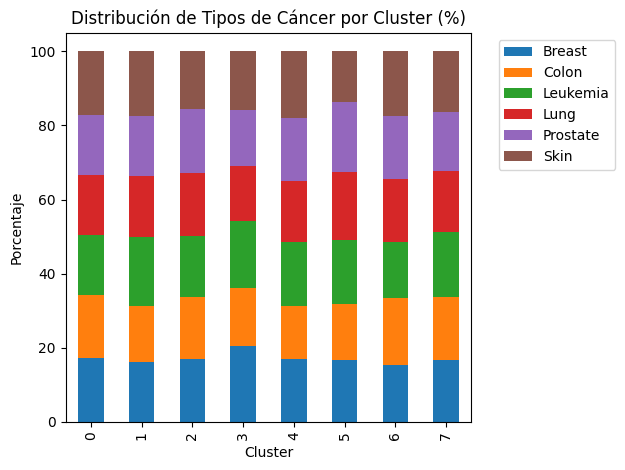

In [ ]:
plt.figure(figsize=(15, 8))
cancer_cluster_dist.plot(kind='bar', stacked=True)
plt.title('Distribución de Tipos de Cáncer por Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Porcentaje')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Agrupando visualizaciones

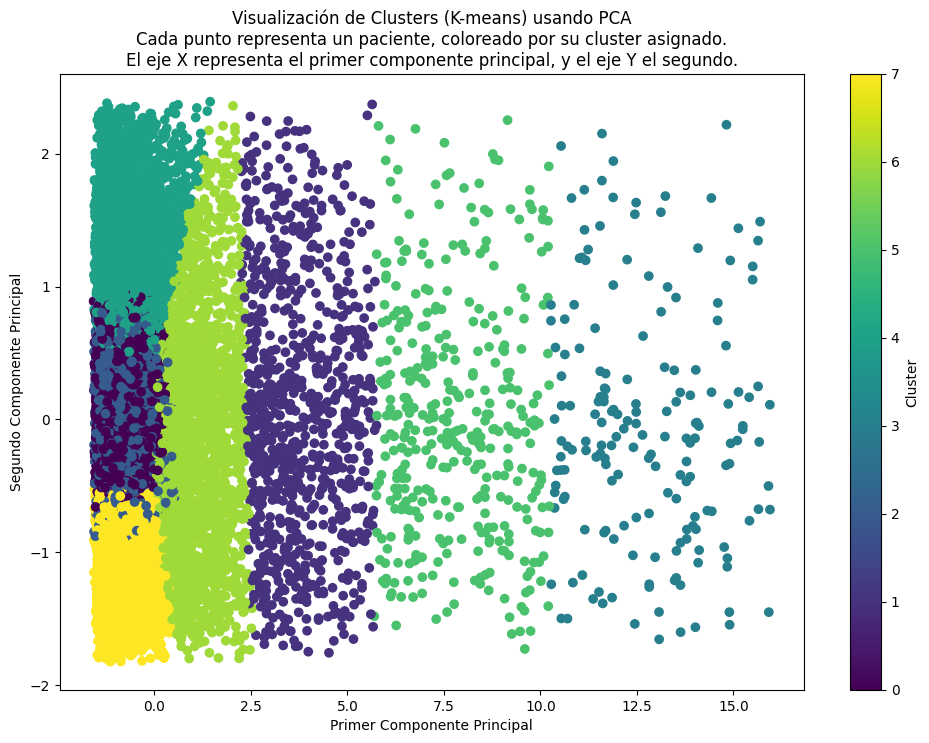

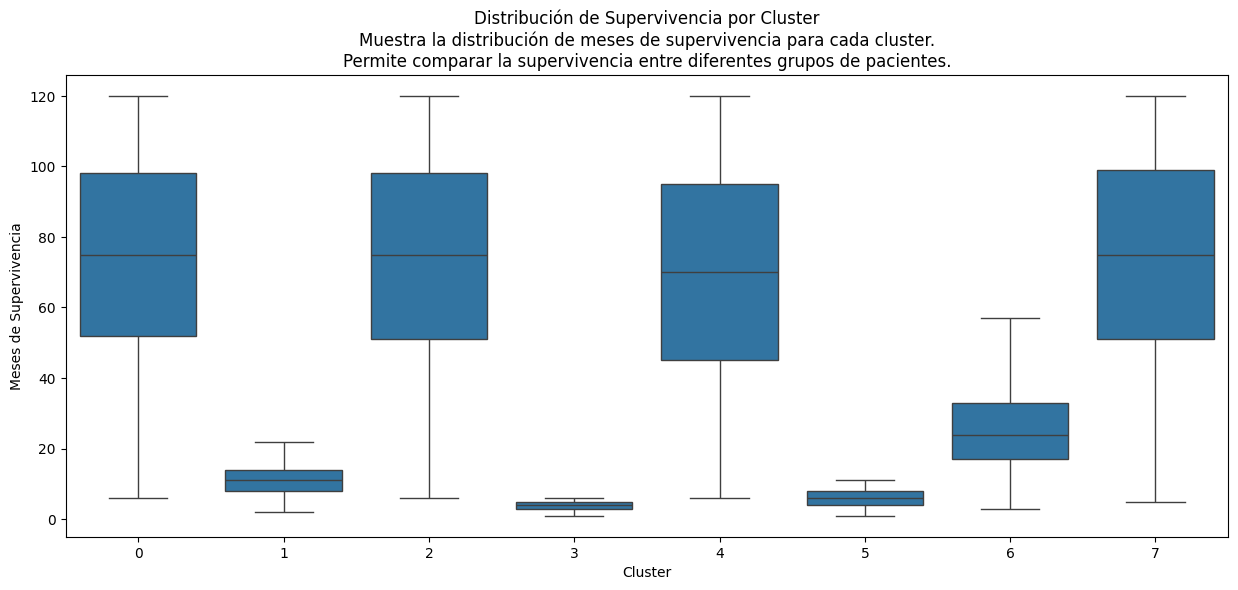

<Figure size 1500x800 with 0 Axes>

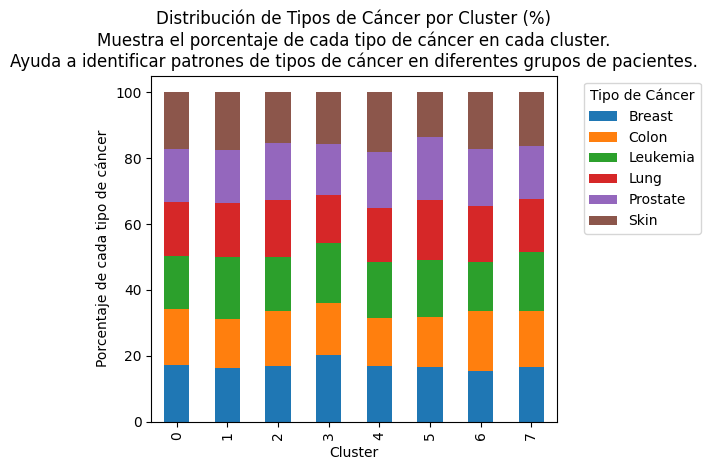

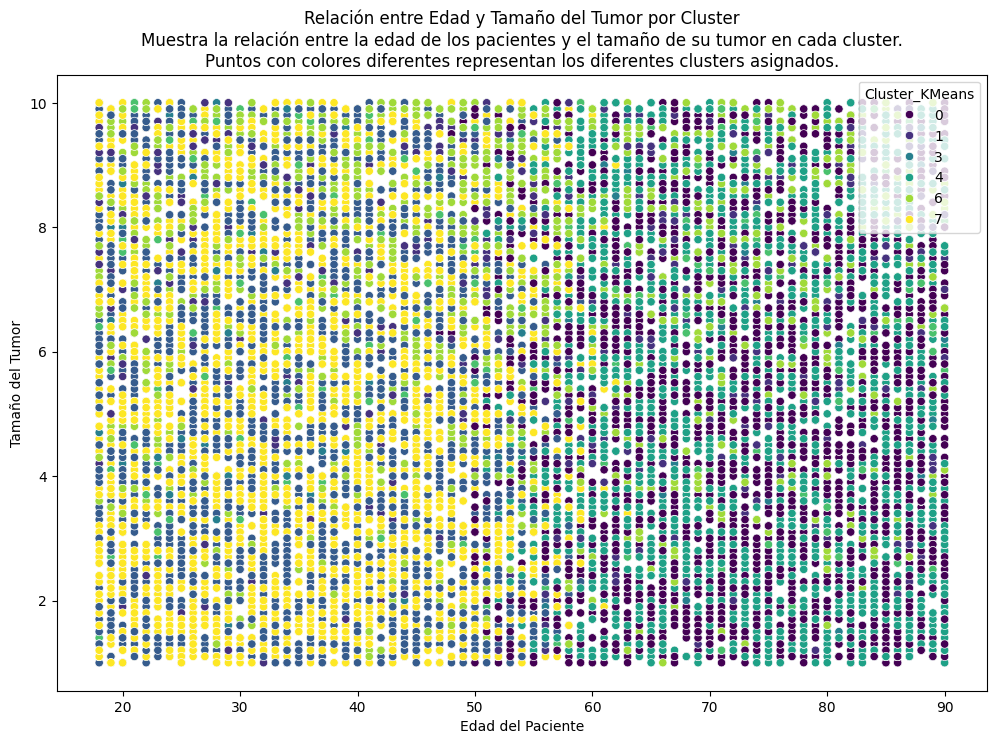

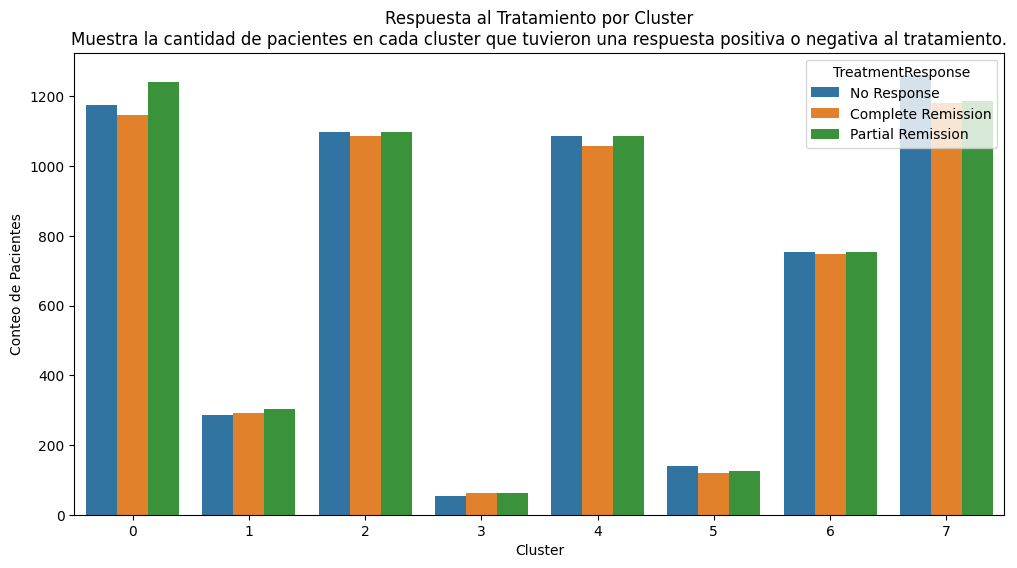

In [ ]:
# Visualización de clusters en 2D usando PCA
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('Visualización de Clusters (K-means) usando PCA\n'
          'Cada punto representa un paciente, coloreado por su cluster asignado.\n'
          'El eje X representa el primer componente principal, y el eje Y el segundo.')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.colorbar(label='Cluster')
plt.show()

# Análisis de características importantes por cluster
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_sin_outliers, x='Cluster_KMeans', y='SurvivalMonths')
plt.title('Distribución de Supervivencia por Cluster\n'
          'Muestra la distribución de meses de supervivencia para cada cluster.\n'
          'Permite comparar la supervivencia entre diferentes grupos de pacientes.')
plt.xlabel('Cluster')
plt.ylabel('Meses de Supervivencia')
plt.show()

# Distribución de tipos de cáncer por cluster
cancer_cluster_dist = pd.crosstab(df_sin_outliers['Cluster_KMeans'],
                                 df_sin_outliers['CancerType'],
                                 normalize='index') * 100
plt.figure(figsize=(15, 8))
cancer_cluster_dist.plot(kind='bar', stacked=True)
plt.title('Distribución de Tipos de Cáncer por Cluster (%)\n'
          'Muestra el porcentaje de cada tipo de cáncer en cada cluster.\n'
          'Ayuda a identificar patrones de tipos de cáncer en diferentes grupos de pacientes.')
plt.xlabel('Cluster')
plt.ylabel('Porcentaje de cada tipo de cáncer')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Tipo de Cáncer')
plt.tight_layout()
plt.show()

# Nuevo gráfico: Relación entre edad y tamaño del tumor por cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_sin_outliers, x='Age', y='TumorSize', hue='Cluster_KMeans', palette='viridis')
plt.title('Relación entre Edad y Tamaño del Tumor por Cluster\n'
          'Muestra la relación entre la edad de los pacientes y el tamaño de su tumor en cada cluster.\n'
           'Puntos con colores diferentes representan los diferentes clusters asignados.')
plt.xlabel('Edad del Paciente')
plt.ylabel('Tamaño del Tumor')
plt.show()

# Nuevo gráfico: Distribución de la respuesta al tratamiento por cluster
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sin_outliers, x='Cluster_KMeans', hue='TreatmentResponse')
plt.title('Respuesta al Tratamiento por Cluster\n'
          'Muestra la cantidad de pacientes en cada cluster que tuvieron una respuesta positiva o negativa al tratamiento.')
plt.xlabel('Cluster')
plt.ylabel('Conteo de Pacientes')
plt.show()

# Los análisis de clustering, particularmente K-means, revelan grupos de pacientes con características distintivas que podrían guiar las estrategias de tratamiento y la investigación.

# 1.*Supervivencia Diferencial*:
# Se observan variaciones significativas en la supervivencia entre los clusters (visualización de la distribución de "SurvivalMonths").  Esto sugiere la necesidad de tratamientos y seguimientos personalizados según el cluster de pertenencia.  Los clusters con menores meses de supervivencia requieren un monitoreo más riguroso y la exploración de nuevas terapias.  Se deben investigar las razones subyacentes de estas diferencias en la supervivencia entre clusters.

# 2. *Tipos de Cáncer Predominantes por Cluster:*
# La distribución de los tipos de cáncer varía entre los clusters. (gráfico de distribución de "CancerType").  Esto es fundamental para el desarrollo de tratamientos dirigidos.  La especialización en los tratamientos debe considerar esta variabilidad. Por ejemplo, si un cluster muestra una alta concentración de un tipo específico de cáncer, los protocolos de tratamiento deberían adaptarse a las particularidades de ese tipo de cáncer, utilizando la información más reciente de la literatura médica y ensayos clínicos.

# 3. *Edad y Tamaño del Tumor*:
# La relación entre la edad y el tamaño del tumor (nuevo gráfico generado) ofrece información relevante para la evaluación de riesgo.  Se recomienda analizar si hay correlaciones significativas entre la edad del paciente, el tamaño del tumor y el cluster. Este análisis podría conducir a una mejor estratificación del riesgo y a estrategias de detección temprana más efectivas.

# 4. *Respuesta al Tratamiento:*
# La respuesta al tratamiento también varía entre los clusters (nuevo gráfico generado). Identificar patrones en la respuesta a los tratamientos específicos por cluster permite optimizar las estrategias terapéuticas y predecir la probabilidad de éxito del tratamiento.  Esto resalta la importancia de la medicina personalizada, considerando factores genéticos y ambientales que pueden influir en la respuesta al tratamiento.

# 5.*Variables significativas adicionales*:
# Se deben explorar variables como "BMI", "Stage", "TreatmentType", "GeneticMarker", etc., para identificar su impacto en el cluster y la supervivencia. Análisis adicionales en variables individuales puede ayudar a determinar qué tan significativas son en los grupos identificados y definir nuevos perfiles de paciente para ensayos clínicos.

# *Recomendaciones:*

## 1. Investigación adicional para comprender los factores biológicos y ambientales que diferencian a los clusters.
## 2. Desarrollo de protocolos de tratamiento personalizados para cada cluster, considerando las características específicas de cada grupo de pacientes.
## 3. Monitoreo continuo de los pacientes, particularmente aquellos en clusters con baja supervivencia.
## 4. Diseño de ensayos clínicos específicos para cada cluster para probar la eficacia de diferentes tratamientos.
## 5. Integración de la información de los clusters con el historial clínico de los pacientes para una atención médica más precisa.